# 雲天による遮光率のモデリング
- 雲は日光を遮る．衛星画像によって遮光率の値が分かっていると仮定しこれを統計モデルによって再現する．
    - 遮光率１：完全に雲
    - 遮光率０：晴天
- 1次元の疑似データを生成する
    - 混合数 3
    - ガウス分布の平均・分散パラメータ $\mu = \{2, 5, 8\} , \sigma^{2} = \{1, 1, 1\}$
    - 混合比 $\pi = \{0.3, 0.5, 0.2\}$
    - シグモイド係数　$a, b$ 
        - $\mathrm{sigmoid}(z) = \frac{1}{1+\exp{(-z)}}, z=ax +b$
    - 疑似データ $f(x) = u\left( \sum_{i} \pi_{i}\mathcal{N}(x ; \mu_{i}, \sigma_{i}^{2}) \right), u(x) = \mathrm{sigmoid(x)}$
- ガウス混合分布に対してシグモイド関数による変換を施すことで値を[0, 1]に収める
- 推定の設定
    - ガウス分布の混合数は既知とする
- 推定パラメータ
    - ガウス分布の平均・分散パラメータ　$ \mu, \sigma$
    - 混合比の重み $\pi$
    - シグモイドの係数 $a, b$

In [479]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import itertools
from common.functions import sigmoid
from common.gradient import numerical_gradient
from PIL import Image
from scipy.stats import multivariate_normal

np.random.seed(1)

%matplotlib inline 

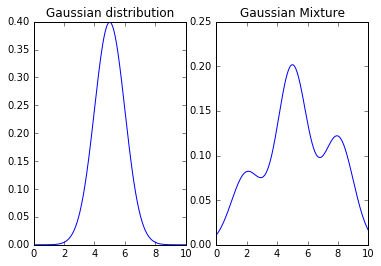

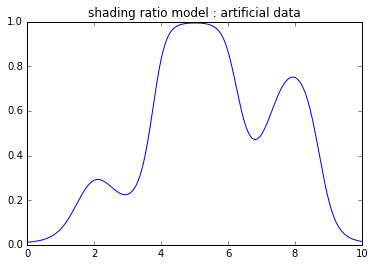

[[ 0.          0.01        0.02        0.03        0.04      ]
 [ 0.0114296   0.01155321  0.01168001  0.01181011  0.01194359]]


In [246]:
# generate 1-dimensional artificial data
x = np.arange(0, 10, 0.01)

# true parameter value
muTrue = np.array([2, 5, 8])
sigmaTrue = np.array([1. ,1. ,1. ])
piTrue = np.array([0.2, 0.5, 0.3])
aTrue = 50
bTrue = -5

# normal distribution density
def dnorm(x, mu, sigma):
    return((1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x-mu)**2/(2*sigma**2)))

plt.subplot(121)
plt.plot(x, dnorm(x, 5, 1))
plt.title('Gaussian distribution')

# Gaussian Mixture density
def dnorm_Mixture(x, mu, sigma, pi):
    values = dnorm(x, mu, sigma)
    return(sum(pi*values))

y = []
for i in x:
    y.append(dnorm_Mixture(i, mu=muTrue, sigma = sigmaTrue, pi = piTrue))
    
plt.subplot(122)
plt.plot(x,  y)
plt.title('Gaussian Mixture')
plt.show()

# logistic sigmoid function
def sigmoid(z):
    return(1/(1+np.exp(-z)))

# shading ratio model
def ShadeTrue(x, mu, sigma, pi, a, b):
    z = a * dnorm_Mixture(x, mu, sigma, pi) +b
    return(sigmoid(z))

y = []
for i in x:
    y.append(ShadeTrue(i, mu=muTrue, sigma=sigmaTrue, pi = piTrue, a=aTrue, b=bTrue))
    
plt.plot(x, y)
plt.title('shading ratio model : artificial data')
plt.show()

# generate artificial data
data = np.vstack((x, y))
print(data[:,0:5])

[[2]
 [5]
 [8]] (3, 1) [[1]
 [1]
 [1]] (3, 1) 3


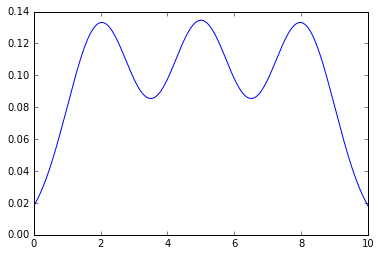

In [420]:
x = np.arange(0, 10, 0.01)
mus = np.array([2,5,8]).reshape(3,1)
covs=np.array([1,1,1]).reshape(3,1)
print(mus, mus.shape, covs, covs.shape, mus.shape[0])
pi = np.array([0.33, 0.33, 0.33])

def GenerateGMM(mus, covs):
    dim = mus.shape[1]
    norms = {}
    for i in range(mus.shape[0]):
        mu = mus[i, :]
        cov = covs[i, :].reshape(dim, dim)
        # print(mu, cov)
        norms[str(i)] = multivariate_normal(mean = mu, cov=cov)
    return(norms)

mix = GenerateGMM(mus = mus, covs = covs)

def MixtureValue(x, GMMmodel, pi):
    values = []
    for i in range(len(pi)):
        values.append(GMMmodel[str(i)].pdf(x))
    return(sum(values*pi))

y = []
[y.append(MixtureValue(x = i, GMMmodel=mix, pi=pi)) for i in x]
    
plt.plot(x, y)
plt.show()

def BregmanDivergence(f, g, a):
    lg1 = np.log((1.-f)/(1.-g))
    lg2 = np.log(g*(1.-f)/f/(1.-g))
    
    allloss = lg1/a - f * lg2/a
    return(np.mean(allloss))
    


In [486]:
class ShadeModel:
    
    # initialize variable
    # input_size : number of data point
    # input_lim : defined area limit, 1D -> [x], 2D->[x, y]
    # mixture_size : number of mixture
    # logistic coef : given logistic coefficient a, b, (z=ax+b)
    def __init__(self, input_size, input_lim,  mixture_size, logistic_coefficient):
        self.dimension = len(input_lim)
        
        self.params = {}
        '''
        self.params['mus'] = muTrue
        self.params['covs'] = sigmaTrue**2
        self.params['pi'] = piTrue
        '''
        self.params['mus'] = np.random.rand(mixture_size, self.dimension)*input_lim
        
        tmp = np.identity(self.dimension)
        tmp = np.tile(tmp, (mixture_size, 1))
        cov = tmp*input_lim/10
        self.params['covs'] = cov.reshape(mixture_size, self.dimension**2)
        
        weight = np.ones(mixture_size)
        self.params['pi'] = weight/sum(weight)
        # '''
        
        self.logistic_coefficient = logistic_coefficient
        
    def predict(self, x):
        mus = self.params['mus'].reshape(mixture_size, self.dimension)
        covs = self.params['covs'].reshape(mixture_size, self.dimension**2)
        pi = self.params['pi']
        a, b = self.logistic_coefficient
        
        mixture = GenerateGMM(mus = mus, covs = covs)
        
        q = []
        [q.append(MixtureValue(i, GMMmodel=mixture, pi = pi)) for i in x]
        # q = MixtureValue(x, GMMmodel=mixture, pi = pi)
        q = np.array(q)
        g = sigmoid(a*q+b)
        return(np.array(g))
    
    # x : input data, f : true data
    def loss(self, x, f):

        g = self.predict(x)
        
        return(BregmanDivergence(f, g, a = self.logistic_coefficient[0]))
    
    def GenerateGrad(self, x, f):
        loss_param = lambda param: self.loss(x, f)
        
        grads = {}
        
        grads['mus'] = numerical_gradient(loss_param, self.params['mus'])
        grads['covs'] = numerical_gradient(loss_param, self.params['covs'])
        grads['pi'] = numerical_gradient(loss_param, self.params['pi'])
        
        return(grads)
        

        

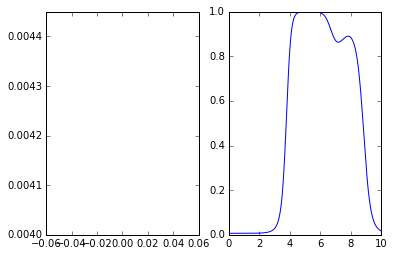

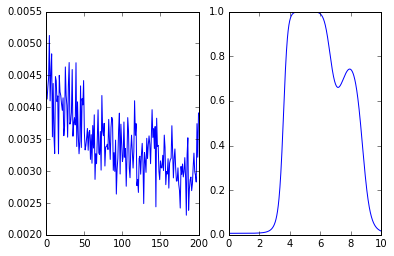

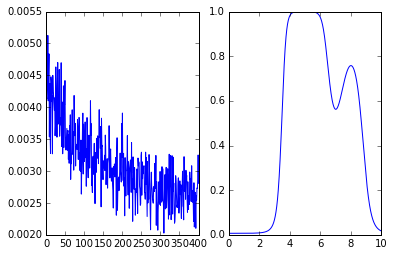

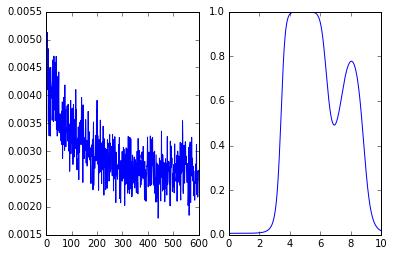

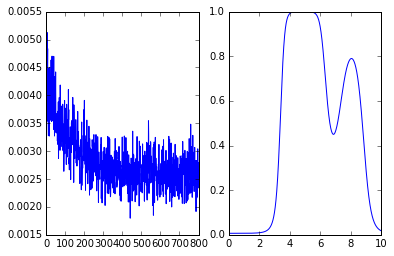

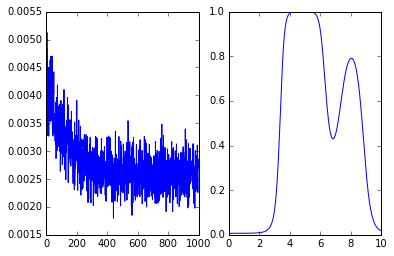

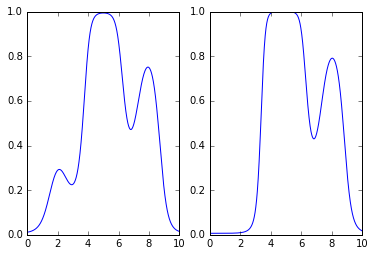

In [495]:
loss_list = []

x = data[0, :]
iter_num = 1001
train_size = x.shape[0]
batch_size = 200
learning_rate = 0.1
epoch = 200
epsilon = 0.01

model = ShadeModel(input_size=train_size, input_lim = [10], mixture_size=3, logistic_coefficient=[50. , -5])

for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x[batch_mask]
    data_batch = data[1, batch_mask]
    
    # compute gradient
    grad = model.GenerateGrad(x_batch, data_batch)
    
    # update parameters
    for key in ('mus', 'covs', 'pi'):
        model.params[key] -= learning_rate * grad[key]
        
    model.params['pi'][model.params['pi'] < epsilon] = epsilon
    model.params['pi'] = model.params['pi']/np.sum(model.params['pi'])
    
    loss = model.loss(x_batch, data_batch)
    loss_list.append(loss)
    
    if(i % epoch ==0):
        
        plt.subplot(121)
        plt.plot(range(i+1), loss_list)
        # plt.xlim(xmin = 0, xmax = iter_num)
        
        y = model.predict(x)
        plt.subplot(122)
        plt.plot(x, y)
        # plt.xlim(xmin = 0, xmax = 10)
        # plt.ylim(ymin = 0, ymax = 1)
        plt.show()
        
# compare result
plt.subplot(121)
plt.plot(x , data[1 , :])
# plt.xlim(xmin = 0, xmax = 10)
# plt.ylim(ymin = 0, ymax = 1)

plt.subplot(122)
plt.plot(x , model.predict(x))
# plt.xlim(xmin = 0, xmax = 10)
# plt.ylim(ymin = 0, ymax = 1)
plt.show()

In [494]:
model.params


array([ 2.  ,  1.  ,  0.01])

(1000,)


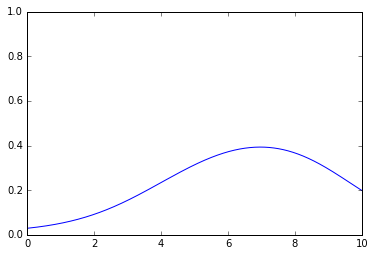

[[ 9.68261576]
 [ 3.13424178]
 [ 6.92322616]]
{'covs': array([[-0.00012311],
       [ 0.0002191 ],
       [ 0.00023196]]), 'pi': array([-0.01054263, -0.02306251, -0.02297712]), 'mus': array([[ 0.00144564],
       [-0.00118504],
       [ 0.00121975]])}


In [439]:
print(x.shape)
Model = ShadeModel(input_size=1000., input_lim=[10], mixture_size=3, logistic_coefficient=[50, -5])
g = np.zeros(len(x))
for i in range(len(x)):
    g[i] = Model.predict(x[i])
     
plt.plot(x, g)
plt.ylim(0,1)
plt.show()

print(Model.params['mus'])

grads = Model.Ge(x, data[1, : ])
print(grads)


In [422]:
def numerical_gradient(loss, )

0.0018303244369887147